# Motor Vehicle Crashes in Staten Island

In [1]:
#Import Libraries
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as md
import seaborn as sns
import pandas as pd
import statsmodels.api as sm
from datetime import datetime
import numpy as np
import random
import gmaps
import gmaps.datasets
import os
import json
import chart_studio.plotly as py
import plotly.graph_objs as go
import ipywidgets as widgets
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import plotly.express as px
import cufflinks as cf
from scipy import special
import plotly.express as px
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
cf.go_offline()

In [2]:
#Dataset from NYC Open Data NYPD Motor Vehicle Collisions - Crashes (July 2012 - Present)
MC = pd.read_json('https://data.cityofnewyork.us/resource/h9gi-nx95.json?$limit=18000000&$offset=0')

In [3]:
#Data Cleaning
SI = MC['borough']=='STATEN ISLAND'

MC_SI = MC[SI]
print(MC_SI.shape)

MC_SI_NotNull = MC_SI[MC_SI.location.notnull()]
print(MC_SI_NotNull.shape)

data = [ 'crash_date', 
        'crash_time', 
        'borough', 
        'zip_code', 
        'latitude', 
        'longitude', 
        'location', 
        'number_of_persons_injured', 
        'number_of_persons_killed', 
        'number_of_pedestrians_injured', 
        'number_of_pedestrians_killed', 
        'number_of_cyclist_injured', 
        'number_of_cyclist_killed', 
        'number_of_motorist_injured',
        'number_of_motorist_killed',
        'contributing_factor_vehicle_1', 
        'contributing_factor_vehicle_2', 
        'contributing_factor_vehicle_3',  
        'vehicle_type_code1', 
        'vehicle_type_code2', 
        'vehicle_type_code_3']

MC_SI = MC_SI_NotNull[data]
print(MC_SI.shape)

(52034, 29)
(50670, 29)
(50670, 21)


In [4]:
#Viewing the Cleaned Dataset and getting some statistics 

MC_SI.info()

MC_SI.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50670 entries, 18 to 1774936
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   crash_date                     50670 non-null  object        
 1   crash_time                     50670 non-null  datetime64[ns]
 2   borough                        50670 non-null  object        
 3   zip_code                       50670 non-null  object        
 4   latitude                       50670 non-null  float64       
 5   longitude                      50670 non-null  float64       
 6   location                       50670 non-null  object        
 7   number_of_persons_injured      50670 non-null  float64       
 8   number_of_persons_killed       50669 non-null  float64       
 9   number_of_pedestrians_injured  50670 non-null  int64         
 10  number_of_pedestrians_killed   50670 non-null  int64         
 11  number_of_cy

,latitude,longitude,number_of_persons_injured,number_of_persons_killed,number_of_pedestrians_injured,number_of_pedestrians_killed,number_of_cyclist_injured,number_of_cyclist_killed,number_of_motorist_injured,number_of_motorist_killed
count,50670.000000,50670.000000,50670.000000,50669.000000,50670.000000,50670.000000,50670.000000,50670.000000,50670.000000,50670.000000
mean,40.549238,-74.054083,0.258753,0.001480,0.038583,0.000632,0.007065,0.000059,0.212769,0.000789
std,1.262130,2.304462,0.660076,0.039459,0.202978,0.025896,0.083994,0.007694,0.635592,0.028780
min,0.000000,-74.254532,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.559540,-74.155796,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,40.592185,-74.114245,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,40.619034,-74.089372,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,40.908127,0.000000,22.000000,2.000000,6.000000,2.000000,2.000000,1.000000,22.000000,2.000000


### Looking into the Number of Injured/Killed

In [5]:
#Making a dataset for Number of Injured/Killed incidents

data1 = MC_SI[['number_of_persons_injured',
 'number_of_persons_killed',
 'number_of_pedestrians_injured',
 'number_of_pedestrians_killed',
 'number_of_cyclist_injured',
 'number_of_cyclist_killed',
 'number_of_motorist_injured',
 'number_of_motorist_killed']]

data1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50670 entries, 18 to 1774936
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   number_of_persons_injured      50670 non-null  float64
 1   number_of_persons_killed       50669 non-null  float64
 2   number_of_pedestrians_injured  50670 non-null  int64  
 3   number_of_pedestrians_killed   50670 non-null  int64  
 4   number_of_cyclist_injured      50670 non-null  int64  
 5   number_of_cyclist_killed       50670 non-null  int64  
 6   number_of_motorist_injured     50670 non-null  int64  
 7   number_of_motorist_killed      50670 non-null  int64  
dtypes: float64(2), int64(6)
memory usage: 3.5 MB


In [6]:
#Getting the Total number of incidents for each case and the number of max incidents for each case

class color:
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0;0m'

count =len(data1)

print(color.UNDERLINE  + color.BOLD  + 'Total Incidents'  + color.END )
print(count)


total_sum = data1.sum()

print(color.UNDERLINE  + color.BOLD  + 'Total Incidents for each case'  + color.END )
print(total_sum)


Max = data1.max()

print(color.UNDERLINE  + color.BOLD  + 'Max Incidents for each case'  + color.END )
print(Max)

Total Incidents
50670
Total Incidents for each case
number_of_persons_injured        13111.0
number_of_persons_killed            75.0
number_of_pedestrians_injured     1955.0
number_of_pedestrians_killed        32.0
number_of_cyclist_injured          358.0
number_of_cyclist_killed             3.0
number_of_motorist_injured       10781.0
number_of_motorist_killed           40.0
dtype: float64
Max Incidents for each case
number_of_persons_injured        22.0
number_of_persons_killed          2.0
number_of_pedestrians_injured     6.0
number_of_pedestrians_killed      2.0
number_of_cyclist_injured         2.0
number_of_cyclist_killed          1.0
number_of_motorist_injured       22.0
number_of_motorist_killed         2.0
dtype: float64


In [7]:
#Creating a bar graph for the total of each incidents

total_sum1= total_sum.sort_values(ascending=False).rename_axis('Incidents').reset_index(name='counts')

fig1 = px.bar(total_sum1, x = total_sum1['Incidents'], y = total_sum1['counts'], text = total_sum1['counts'], labels={"counts": "Number of Incidents"})
fig1.update_layout(font_family="Open Sans")
fig1.update_layout(font_color='Black')
fig1.update_traces(texttemplate='%{text:.5s}', textposition='outside')
fig1.update_layout(uniformtext_minsize=7, uniformtext_mode='hide')
fig1.update_layout(height=600)
fig1.update_layout(barmode='group', xaxis_tickangle=-45)
fig1.update_layout(title='(Total Incidents)')
fig1.update_layout(title_xanchor="left")
fig1.show()

In [8]:
#filtering out the incidents that have no injury

filter1 = ['0']
Z_T = MC_SI[~MC_SI.number_of_persons_injured.isin(filter1)]

Z_TF = Z_T.groupby(['number_of_persons_injured']).zip_code.value_counts().reset_index(name='counts')
print(Z_TF)

#Creating bar graph of the number of persons injured in each incident and grouped them by zip codes
fig2 = px.histogram(Z_TF, x = 'zip_code', y = 'counts', color = 'number_of_persons_injured').update_xaxes(categoryorder='total descending')
fig2.update_layout(font_family="Open Sans")
fig2.update_layout(font_color='Black')
fig2.update_yaxes(title_text= 'Number of Incidents')
fig2.update_layout(width=900)
fig2.update_layout(uniformtext_minsize=10)
fig2.update_layout(barmode='group', xaxis_tickangle=-45)
fig2.update_layout(dragmode='zoom')
fig2.update_layout(title='(Number of Persons Injured by Zip Code)')
fig2.update_layout(title_xanchor="left")
fig2.show()

    number_of_persons_injured zip_code  counts
0                         1.0    10306    1235
1                         1.0    10304    1060
2                         1.0    10301     928
3                         1.0    10312     869
4                         1.0    10305     854
..                        ...      ...     ...
84                       10.0    10306       1
85                       11.0    10310       1
86                       12.0    10310       1
87                       17.0    10301       1
88                       22.0    10301       1

[89 rows x 3 columns]


In [9]:
#filtering out the incidents that have no death
filter1 = ['0']
Z_K = MC_SI[~MC_SI.number_of_persons_killed.isin(filter1)]

Z_KF = Z_K.groupby(['number_of_persons_killed']).zip_code.value_counts().reset_index(name='counts')
print(Z_KF)

#Creating bar graph of the number of persons killed in each incident and grouped them by zip codes
fig3 = px.histogram(Z_KF, x = 'zip_code', y = 'counts', color = 'number_of_persons_killed').update_xaxes(categoryorder='total descending')
fig3.update_layout(font_family="Open Sans")
fig3.update_layout(font_color='Black')
fig3.update_yaxes(title_text= 'Number of Incidents')
fig3.update_layout(width=900)
fig3.update_layout(uniformtext_minsize=10)
fig3.update_layout(barmode='group', xaxis_tickangle=-45)
fig3.update_layout(dragmode='zoom')
fig3.update_layout(title='(Number of Persons Killed by Zip Code)')
fig3.update_layout(title_xanchor="left")
fig3.show()

    number_of_persons_killed zip_code  counts
0                        1.0    10306      14
1                        1.0    10305      12
2                        1.0    10312       8
3                        1.0    10301       7
4                        1.0    10314       7
5                        1.0    10304       6
6                        1.0    10310       5
7                        1.0    10308       4
8                        1.0    10309       3
9                        1.0    10302       2
10                       1.0    10307       2
11                       1.0    10303       1
12                       2.0    10312       2


### Looking into Accidents within Each Zip code

In [10]:
#Creating a bar chart where it shows the total incidents within each zip code
Zip = MC_SI[['zip_code']]
Zip.zip_code.value_counts()
Z=Zip.zip_code.value_counts().rename_axis('Zipcode').reset_index(name='counts')

print(Z)

px.bar(Z, x = 'Zipcode', y = 'counts')

fig4 = px.bar(Z, x = 'Zipcode', y = 'counts', text = 'counts')
fig4.update_layout(font_family="Open Sans")
fig4.update_layout(font_color='Black')
fig4.update_yaxes(title_text= 'Number of Incidents')
fig4.update_traces(texttemplate='%{text:.4s}', textposition='outside')
fig4.update_layout(uniformtext_minsize=7, uniformtext_mode='hide')
fig4.update_layout(height=600)
fig4.update_layout(barmode='relative', xaxis_tickangle=-45)
fig4.update_layout(title='(Total Motor Crashes by Zip code)')
fig4.update_layout(title_xanchor="left")
fig4.show()

   Zipcode  counts
0    10306    8574
1    10304    6869
2    10301    6580
3    10312    6347
4    10305    5901
5    10314    4142
6    10310    3864
7    10309    3515
8    10308    2722
9    10307    1023
10   10302     583
11   10303     550


### Looking into Motor Crash Vehicle Types

In [11]:
#Listing all the Vehicle types that are a contribution of the motor crashes
Vehicle_T1 = MC_SI[['vehicle_type_code1']]
V=Vehicle_T1.vehicle_type_code1.value_counts().rename_axis('Type').reset_index(name='counts')
V1F= V.head(50)
print(V1F)

                                   Type  counts
0                     PASSENGER VEHICLE   16841
1                                 Sedan   12478
2         SPORT UTILITY / STATION WAGON    7766
3   Station Wagon/Sport Utility Vehicle    7431
4                            4 dr sedan     937
5                         Pick-up Truck     914
6                               UNKNOWN     570
7                                 OTHER     565
8                         PICK-UP TRUCK     535
9                                   VAN     466
10                                  BUS     329
11                                  Bus     213
12              SMALL COM VEH(4 TIRES)      129
13                            Box Truck     114
14                           Motorcycle     112
15       LARGE COM VEH(6 OR MORE TIRES)      95
16                           MOTORCYCLE      95
17                                 Bike      93
18                                  Van      76
19                          Convertible 

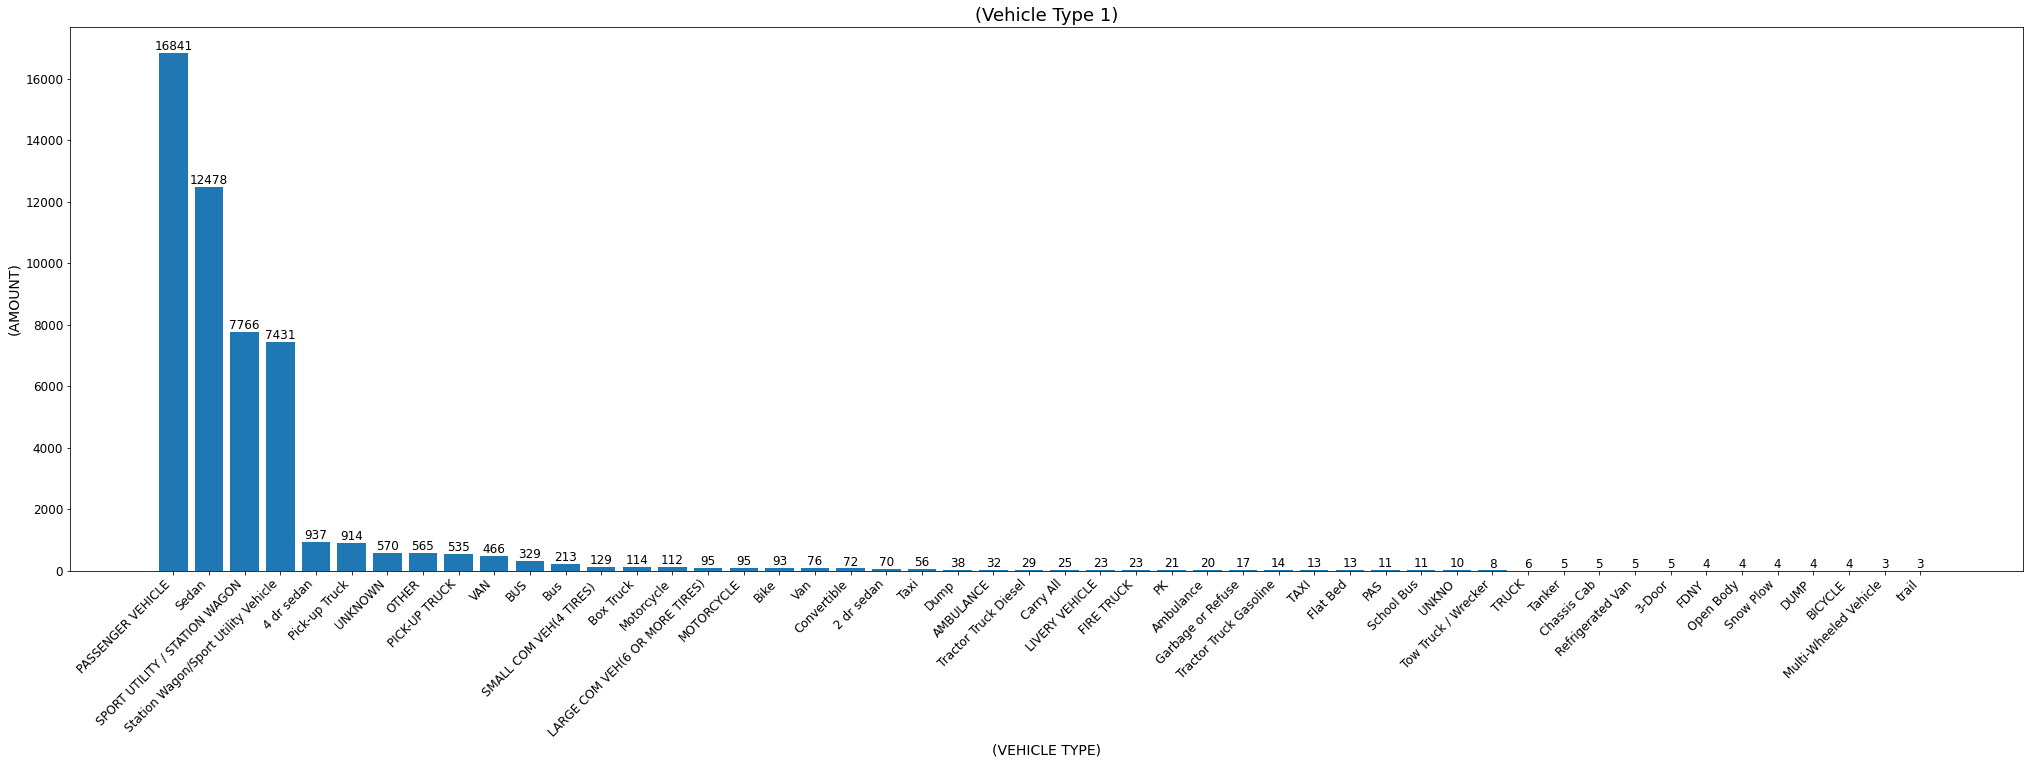

In [12]:
#Creating a bar chart of all the contributing vehicle types to have a better visual
plt.rcParams['figure.figsize'] = (35,10)
plt.bar(V1F['Type'], V1F['counts'])
plt.xlabel('(VEHICLE TYPE)', fontsize = 14)
plt.ylabel('(AMOUNT)', fontsize = 14)
plt.xticks(rotation=45, horizontalalignment='right', fontsize = 12)
plt.yticks(fontsize = 12)
plt.title("(Vehicle Type 1)", fontsize = 18)


for i in range(len(V1F['Type'])):
    plt.text(i,V1F['counts'][i],V1F['counts'][i], ha='center', va='bottom', fontsize = 12)
    
plt.show()

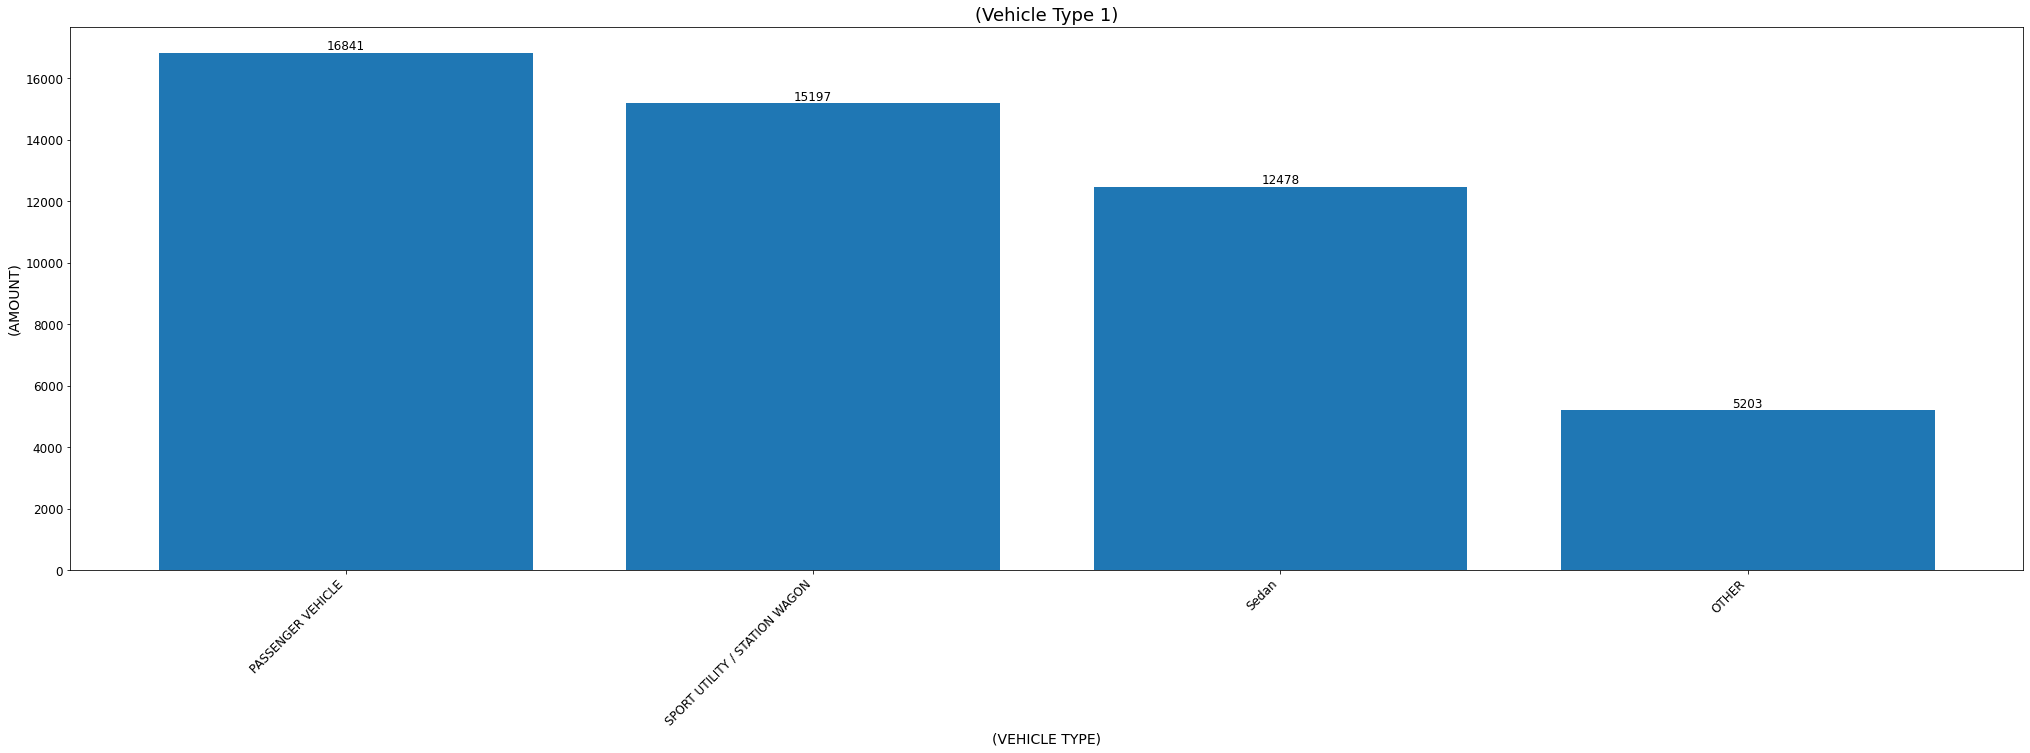

In [13]:
#Creating a bar chart after filtering vehicle 1 types to have a better visual
filter2 = ['PASSENGER VEHICLE', 'Sedan', '4 dr sedan', 'Station Wagon/Sport Utility Vehicle' ,'Pick-up Truck', 'SPORT UTILITY / STATION WAGON', 'UNKNOWN', 'PICK-UP TRUCK', 'VAN', 'BUS', 'Bus', 'SMALL COM VEH(4 TIRES) ', 
           'Box Truck', 'Motorcycle', 'MOTORCYCLE', 'LARGE COM VEH(6 OR MORE TIRES)', 'Bike', 'Van', 'Convertible', '2 dr sedan', 'Taxi', 'Dump', 'AMBULANCE', 
           'Tractor Truck', 'Carry All', 'LIVERY VEHICLE', 'FIRE TRUCK', 'PK', 'Ambulance', 'Garbage or Refuse', 'Tractor Truck Gasoline', 'TAXI' , 'Flat Bed', 'School Bus', 
           'PAS', 'UNKNO', 'Tow Truck / Wrecker', 'TRUCK', 'Tanker', 'Chassis Cab', 'Refrigerated Van', '3-Door',  'Open Body', 'BICYCLE', 'Snow Plow', 'DUMP', 'Motorbike', 'trail']   
V1 = MC_SI[MC_SI.vehicle_type_code1.isin(filter2)]      

VR = V1.replace({'4 dr sedan' : 'OTHER', 'Pick-up Truck' : 'OTHER', 'Station Wagon/Sport Utility Vehicle' : 'SPORT UTILITY / STATION WAGON', 'UNKNOWN' : 'OTHER', 
                'PICK-UP TRUCK' : 'OTHER', 'VAN' : 'OTHER', 'BUS' :'OTHER', 'Bus' : 'OTHER', 'SMALL COM VEH(4 TIRES) ' : 'OTHER', 'Box Truck' : 'OTHER', 
                 'Motorcycle' : 'OTHER' , 'MOTORCYCLE' : 'OTHER', 'LARGE COM VEH(6 OR MORE TIRES)' : 'OTHER', 'Bike' : 'OTHER', 'Van' : 'OTHER',
                'Convertible' : 'OTHER', '2 dr sedan' : 'OTHER', 'Taxi' : 'OTHER', 'Dump' : 'OTHER', 'AMBULANCE' : 'OTHER', 'Tractor Truck Diesel' : 'OTHER',
                'Carry All' : 'OTHER', 'LIVERY VEHICLE' : 'OTHER', 'FIRE TRUCK' : 'OTHER', 'PK' : 'OTHER', 'Ambulance' : 'OTHER', 'Garbage or Refuse' : 'OTHER',
                'Tractor Truck Gasoline' : 'OTHER', 'TAXI' : 'OTHER', 'Flat Bed' : 'OTHER', 'School Bus' : 'OTHER', 'PAS' : 'OTHER', 'UNKNO' : 'OTHER', 
                'Tow Truck / Wrecker' : 'OTHER', 'TRUCK' : 'OTHER', 'Tanker' : 'OTHER', 'Chassis Cab' : 'OTHER', 'Refrigerated Van' : 'OTHER', '3-Door' : 'OTHER', 
                 'FDNY' : 'OTHER', 'Open Body' : 'OTHER', 'BICYCLE' : 'OTHER', 'Snow Plow' : 'OTHER', 'DUMP' : 'OTHER', 'Motorbike' : 'OTHER', 'trail' : 'OTHER'})

V1F=VR.vehicle_type_code1.value_counts().rename_axis('Type').reset_index(name='counts') 


plt.rcParams['figure.figsize'] = (35,10)
plt.bar(V1F['Type'], V1F['counts'])
plt.xlabel('(VEHICLE TYPE)', fontsize = 14)
plt.ylabel('(AMOUNT)', fontsize = 14)
plt.xticks(rotation=45, horizontalalignment='right', fontsize = 12)
plt.yticks(fontsize = 12)
plt.title("(Vehicle Type 1)", fontsize = 18)


for i in range(len(V1F['Type'])):
    plt.text(i,V1F['counts'][i],V1F['counts'][i], ha='center', va='bottom', fontsize = 12)
    
plt.show()

In [14]:
VzF = VR.groupby('vehicle_type_code1')['zip_code'].value_counts().reset_index(name='counts')

print(VzF)

fig5 = px.histogram(VzF, x = 'zip_code', y = 'counts', color = 'vehicle_type_code1').update_xaxes(categoryorder='total descending')
fig5.update_layout(font_family="Open Sans")
fig5.update_layout(font_color='Black')
fig5.update_yaxes(title_text= 'Number of Incidents')
fig5.update_layout(uniformtext_minsize=7, uniformtext_mode='show')
fig5.update_layout(height=600)
fig5.update_layout(barmode = 'relative', xaxis_tickangle=-45)
fig5.update_layout(title='(Vehicle 1 vs Zip Code Bar graph)')
fig5.update_layout(title_xanchor="left")
fig5.show()


fig5x = px.histogram(VzF, x = 'zip_code', y = 'counts', color = 'vehicle_type_code1', labels={"counts": "the Number of Incidents"})
fig5x.update_layout(font_family="Open Sans")
fig5x.update_layout(font_color='Black')
fig5x.update_yaxes(title_text= 'Percentage of Vehicle 1 on the Number of Incidents')
fig5x.update_layout(uniformtext_minsize=7, uniformtext_mode='hide')
fig5x.update_layout(hovermode='x')
fig5x.update_layout(height=600)
fig5x.update_layout(barnorm = 'percent', xaxis_tickangle=-45)
fig5x.update_layout(title='(Vehicle 1 vs Zip Code Percentage Bar graph)')
fig5x.update_layout(title_xanchor="left")
fig5x.show()

               vehicle_type_code1 zip_code  counts
0                           OTHER    10306     865
1                           OTHER    10304     709
2                           OTHER    10312     685
3                           OTHER    10301     660
4                           OTHER    10305     627
5                           OTHER    10309     413
6                           OTHER    10310     402
7                           OTHER    10314     301
8                           OTHER    10308     288
9                           OTHER    10307     142
10                          OTHER    10302      65
11                          OTHER    10303      46
12              PASSENGER VEHICLE    10306    2733
13              PASSENGER VEHICLE    10312    2061
14              PASSENGER VEHICLE    10314    2056
15              PASSENGER VEHICLE    10301    2025
16              PASSENGER VEHICLE    10304    1998
17              PASSENGER VEHICLE    10305    1823
18              PASSENGER VEHIC

In [15]:
#Creating bar graph and percentage bar graph for vehicle 2 type vs zip code

filter2 = ['PASSENGER VEHICLE', 'Sedan', '4 dr sedan', 'Station Wagon/Sport Utility Vehicle' ,'Pick-up Truck', 'SPORT UTILITY / STATION WAGON', 'UNKNOWN', 'PICK-UP TRUCK', 'VAN', 'BUS', 'Bus', 'SMALL COM VEH(4 TIRES) ', 
           'Box Truck', 'Motorcycle', 'MOTORCYCLE', 'LARGE COM VEH(6 OR MORE TIRES)', 'Bike', 'Van', 'Convertible', '2 dr sedan', 'Taxi', 'Dump', 'AMBULANCE', 
           'Tractor Truck', 'Carry All', 'LIVERY VEHICLE', 'FIRE TRUCK', 'PK', 'Ambulance', 'Garbage or Refuse', 'Tractor Truck Gasoline', 'TAXI' , 'Flat Bed', 'School Bus', 
           'PAS', 'UNKNO', 'Tow Truck / Wrecker', 'TRUCK', 'Tanker', 'Chassis Cab', 'Refrigerated Van', '3-Door',  'Open Body', 'BICYCLE', 'Snow Plow', 'DUMP', 'Motorbike', 'trail']   
V2 = MC_SI[MC_SI.vehicle_type_code2.isin(filter2)]      

VR2 = V2.replace({'4 dr sedan' : 'OTHER', 'Pick-up Truck' : 'OTHER', 'Station Wagon/Sport Utility Vehicle' : 'SPORT UTILITY / STATION WAGON', 'UNKNOWN' : 'OTHER', 
                'PICK-UP TRUCK' : 'OTHER', 'VAN' : 'OTHER', 'BUS' :'OTHER', 'Bus' : 'OTHER', 'SMALL COM VEH(4 TIRES) ' : 'OTHER', 'Box Truck' : 'OTHER', 
                 'Motorcycle' : 'OTHER' , 'MOTORCYCLE' : 'OTHER', 'LARGE COM VEH(6 OR MORE TIRES)' : 'OTHER', 'Bike' : 'OTHER', 'Van' : 'OTHER',
                'Convertible' : 'OTHER', '2 dr sedan' : 'OTHER', 'Taxi' : 'OTHER', 'Dump' : 'OTHER', 'AMBULANCE' : 'OTHER', 'Tractor Truck Diesel' : 'OTHER',
                'Carry All' : 'OTHER', 'LIVERY VEHICLE' : 'OTHER', 'FIRE TRUCK' : 'OTHER', 'PK' : 'OTHER', 'Ambulance' : 'OTHER', 'Garbage or Refuse' : 'OTHER',
                'Tractor Truck Gasoline' : 'OTHER', 'TAXI' : 'OTHER', 'Flat Bed' : 'OTHER', 'School Bus' : 'OTHER', 'PAS' : 'OTHER', 'UNKNO' : 'OTHER', 
                'Tow Truck / Wrecker' : 'OTHER', 'TRUCK' : 'OTHER', 'Tanker' : 'OTHER', 'Chassis Cab' : 'OTHER', 'Refrigerated Van' : 'OTHER', '3-Door' : 'OTHER', 
                 'FDNY' : 'OTHER', 'Open Body' : 'OTHER', 'BICYCLE' : 'OTHER', 'Snow Plow' : 'OTHER', 'DUMP' : 'OTHER', 'Motorbike' : 'OTHER', 'trail' : 'OTHER'})


VF2 = VR2.vehicle_type_code2.value_counts().rename_axis('Type').reset_index(name='counts')




V2F = VR2.groupby('vehicle_type_code2')['zip_code'].value_counts().reset_index(name='counts')
print(V2F)


fig6 = px.histogram(V2F, x = 'zip_code', y = 'counts', color = 'vehicle_type_code2').update_xaxes(categoryorder='total descending')
fig6.update_layout(font_family="Open Sans")
fig6.update_layout(font_color='Black')
fig6.update_yaxes(title_text= 'Number of Incidents')
fig6.update_layout(uniformtext_minsize=7, uniformtext_mode='hide')
fig6.update_layout(height=600)
fig6.update_layout(barmode='relative', xaxis_tickangle=-45)
fig6.update_layout(title='(Vehicle 2 vs Zip Code Bar graph)')
fig6.update_layout(title_xanchor="left")
fig6.show()


fig6c = px.histogram(V2F, x = 'zip_code', y = 'counts', color = 'vehicle_type_code2')
fig6c.update_layout(font_family="Open Sans")
fig6c.update_layout(font_color='Black')
fig6c.update_yaxes(title_text= 'Percentage of Vehicle 2 on the Number of Incidents')
fig6c.update_layout(uniformtext_minsize=7, uniformtext_mode='hide')
fig6c.update_layout(height=600)
fig6c.update_layout(barnorm='percent', xaxis_tickangle=-45)
fig6c.update_layout(title='(Vehicle 2 vs Zip Code Percentage Bar graph)')
fig6c.update_layout(title_xanchor="left")
fig6c.show()



               vehicle_type_code2 zip_code  counts
0                           OTHER    10306    1100
1                           OTHER    10304     948
2                           OTHER    10312     908
3                           OTHER    10301     904
4                           OTHER    10305     849
5                           OTHER    10310     571
6                           OTHER    10309     507
7                           OTHER    10314     502
8                           OTHER    10308     357
9                           OTHER    10307     181
10                          OTHER    10303     103
11                          OTHER    10302      99
12              PASSENGER VEHICLE    10306    2239
13              PASSENGER VEHICLE    10314    1653
14              PASSENGER VEHICLE    10312    1650
15              PASSENGER VEHICLE    10304    1515
16              PASSENGER VEHICLE    10301    1505
17              PASSENGER VEHICLE    10305    1382
18              PASSENGER VEHIC

In [16]:
#Creating bar graph and percentage bar graph for vehicle 2 type vs zip code

filter2 = ['PASSENGER VEHICLE', 'Sedan', '4 dr sedan', 'Station Wagon/Sport Utility Vehicle' ,'Pick-up Truck', 'SPORT UTILITY / STATION WAGON', 'UNKNOWN', 'PICK-UP TRUCK', 'VAN', 'BUS', 'Bus', 'SMALL COM VEH(4 TIRES) ', 
           'Box Truck', 'Motorcycle', 'MOTORCYCLE', 'LARGE COM VEH(6 OR MORE TIRES)', 'Bike', 'Van', 'Convertible', '2 dr sedan', 'Taxi', 'Dump', 'AMBULANCE', 
           'Tractor Truck', 'Carry All', 'LIVERY VEHICLE', 'FIRE TRUCK', 'PK', 'Ambulance', 'Garbage or Refuse', 'Tractor Truck Gasoline', 'TAXI' , 'Flat Bed', 'School Bus', 
           'PAS', 'UNKNO', 'Tow Truck / Wrecker', 'TRUCK', 'Tanker', 'Chassis Cab', 'Refrigerated Van', '3-Door',  'Open Body', 'BICYCLE', 'Snow Plow', 'DUMP', 'Motorbike', 'trail']   
V3 = MC_SI[MC_SI.vehicle_type_code_3.isin(filter2)]      

VR3 = V3.replace({'4 dr sedan' : 'OTHER', 'Pick-up Truck' : 'OTHER', 'Station Wagon/Sport Utility Vehicle' : 'SPORT UTILITY / STATION WAGON', 'UNKNOWN' : 'OTHER', 
                'PICK-UP TRUCK' : 'OTHER', 'VAN' : 'OTHER', 'BUS' :'OTHER', 'Bus' : 'OTHER', 'SMALL COM VEH(4 TIRES) ' : 'OTHER', 'Box Truck' : 'OTHER', 
                 'Motorcycle' : 'OTHER' , 'MOTORCYCLE' : 'OTHER', 'LARGE COM VEH(6 OR MORE TIRES)' : 'OTHER', 'Bike' : 'OTHER', 'Van' : 'OTHER',
                'Convertible' : 'OTHER', '2 dr sedan' : 'OTHER', 'Taxi' : 'OTHER', 'Dump' : 'OTHER', 'AMBULANCE' : 'OTHER', 'Tractor Truck Diesel' : 'OTHER',
                'Carry All' : 'OTHER', 'LIVERY VEHICLE' : 'OTHER', 'FIRE TRUCK' : 'OTHER', 'PK' : 'OTHER', 'Ambulance' : 'OTHER', 'Garbage or Refuse' : 'OTHER',
                'Tractor Truck Gasoline' : 'OTHER', 'TAXI' : 'OTHER', 'Flat Bed' : 'OTHER', 'School Bus' : 'OTHER', 'PAS' : 'OTHER', 'UNKNO' : 'OTHER', 
                'Tow Truck / Wrecker' : 'OTHER', 'TRUCK' : 'OTHER', 'Tanker' : 'OTHER', 'Chassis Cab' : 'OTHER', 'Refrigerated Van' : 'OTHER', '3-Door' : 'OTHER', 
                 'FDNY' : 'OTHER', 'Open Body' : 'OTHER', 'BICYCLE' : 'OTHER', 'Snow Plow' : 'OTHER', 'DUMP' : 'OTHER', 'Motorbike' : 'OTHER', 'trail' : 'OTHER'})

VF3 = VR3.vehicle_type_code_3.value_counts().rename_axis('Type').reset_index(name='counts')


V3F = VR3.groupby('vehicle_type_code_3')['zip_code'].value_counts().reset_index(name='counts')
print(V3F)


fig7 = px.histogram(V3F, x = 'zip_code', y = 'counts', color = 'vehicle_type_code_3').update_xaxes(categoryorder='total descending')
fig7.update_layout(font_family="Open Sans")
fig7.update_layout(font_color='Black')
fig7.update_yaxes(title_text= 'Number of Incidents')
fig7.update_layout(uniformtext_minsize=7, uniformtext_mode='hide')
fig7.update_layout(height=600)
fig7.update_layout(barmode='relative', xaxis_tickangle=-45)
fig7.update_layout(title='(Vehicle 3 vs Zip Code Bar graph)')
fig7.update_layout(title_xanchor="left")
fig7.show()


fig7c = px.histogram(V3F, x = 'zip_code', y = 'counts', color = 'vehicle_type_code_3')
fig7c.update_layout(font_family="Open Sans")
fig7c.update_layout(font_color='Black')
fig7c.update_yaxes(title_text= 'Percentage of Vehicle 3 on the Number of Incidents')
fig7c.update_layout(uniformtext_minsize=7, uniformtext_mode='hide')
fig7c.update_layout(height=600)
fig7c.update_layout(barnorm='percent', xaxis_tickangle=-45)
fig7c.update_layout(title='(Vehicle 3 vs Zip Code Percentage Bar graph)')
fig7c.update_layout(title_xanchor="left")
fig7c.show()

              vehicle_type_code_3 zip_code  counts
0                           OTHER    10312      52
1                           OTHER    10304      48
2                           OTHER    10301      47
3                           OTHER    10306      45
4                           OTHER    10305      37
5                           OTHER    10314      26
6                           OTHER    10310      25
7                           OTHER    10308      24
8                           OTHER    10309      21
9                           OTHER    10307      10
10                          OTHER    10302       3
11                          OTHER    10303       1
12              PASSENGER VEHICLE    10306     200
13              PASSENGER VEHICLE    10312     171
14              PASSENGER VEHICLE    10301     150
15              PASSENGER VEHICLE    10314     139
16              PASSENGER VEHICLE    10304     132
17              PASSENGER VEHICLE    10305     132
18              PASSENGER VEHIC

### Looking into the Contributing Factor of Vehicles

In [17]:
#Listing all the contributing factor for vehicle 1 that has a contribution of the motor crashes and filtering out unspecified, 80, and 1

MC_Vehicle1 = MC_SI[['contributing_factor_vehicle_1']]
MC_Vehicle1.contributing_factor_vehicle_1.value_counts()


filter = ['Unspecified', '80', '1']
C = MC_SI[~MC_SI.contributing_factor_vehicle_1.isin(filter)]

C.contributing_factor_vehicle_1.value_counts()
C1F = C.contributing_factor_vehicle_1.value_counts().rename_axis('Incidents').reset_index(name='counts')
print(C1F)

                                            Incidents  counts
0                      Driver Inattention/Distraction    9486
1                       Failure to Yield Right-of-Way    3016
2                                    Backing Unsafely    2205
3                               Following Too Closely    1843
4                                     Other Vehicular    1218
5                                     Fatigued/Drowsy    1139
6                                  Turning Improperly     963
7                                   Pavement Slippery     910
8                         Traffic Control Disregarded     829
9                                 Driver Inexperience     737
10                     Passing or Lane Usage Improper     676
11                                Alcohol Involvement     672
12                                Passing Too Closely     658
13                                       Unsafe Speed     518
14                            Prescription Medication     427
15      

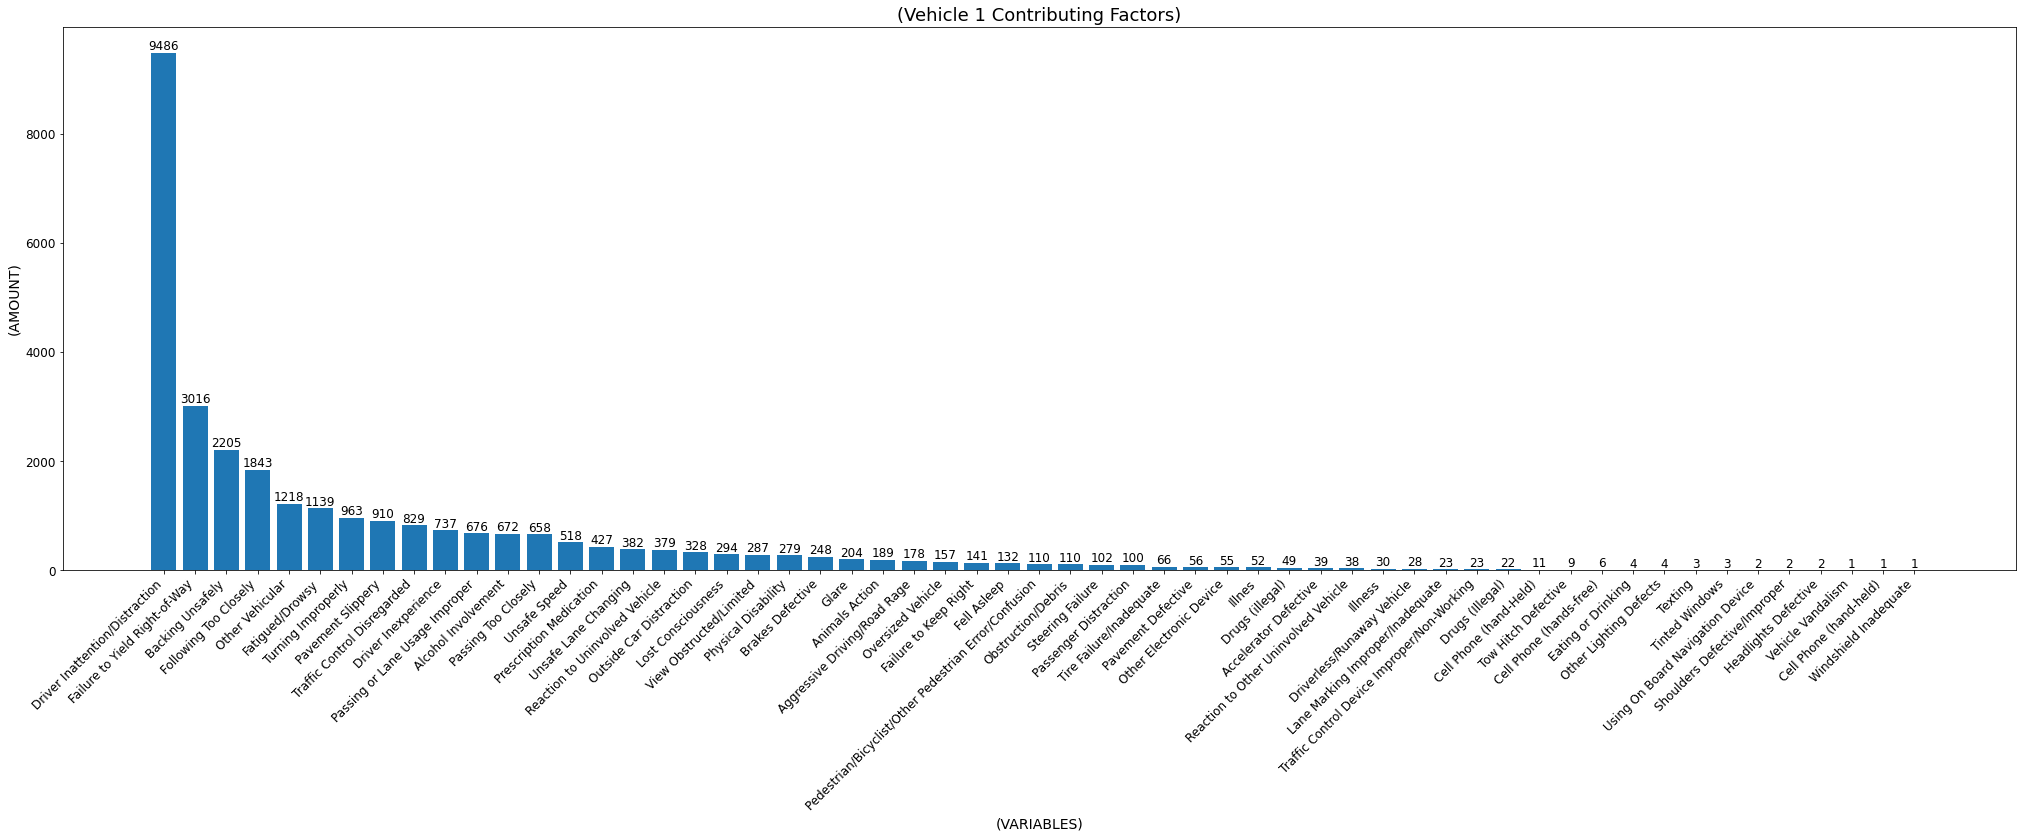

In [18]:
#Creating a bar chart of all the contributing factors for vehicle 1 to have a better visual
plt.rcParams['figure.figsize'] = (35,10)
plt.bar(C1F['Incidents'], C1F['counts'])
plt.xlabel('(VARIABLES)', fontsize = 14)
plt.ylabel('(AMOUNT)', fontsize = 14)
plt.xticks(rotation=45, horizontalalignment='right', fontsize = 12)
plt.yticks(fontsize = 12)
plt.title("(Vehicle 1 Contributing Factors)", fontsize = 18)


for i in range(len(C1F['Incidents'])):
    plt.text(i,C1F['counts'][i],C1F['counts'][i], ha='center', va='bottom', fontsize = 12)
    
plt.show()

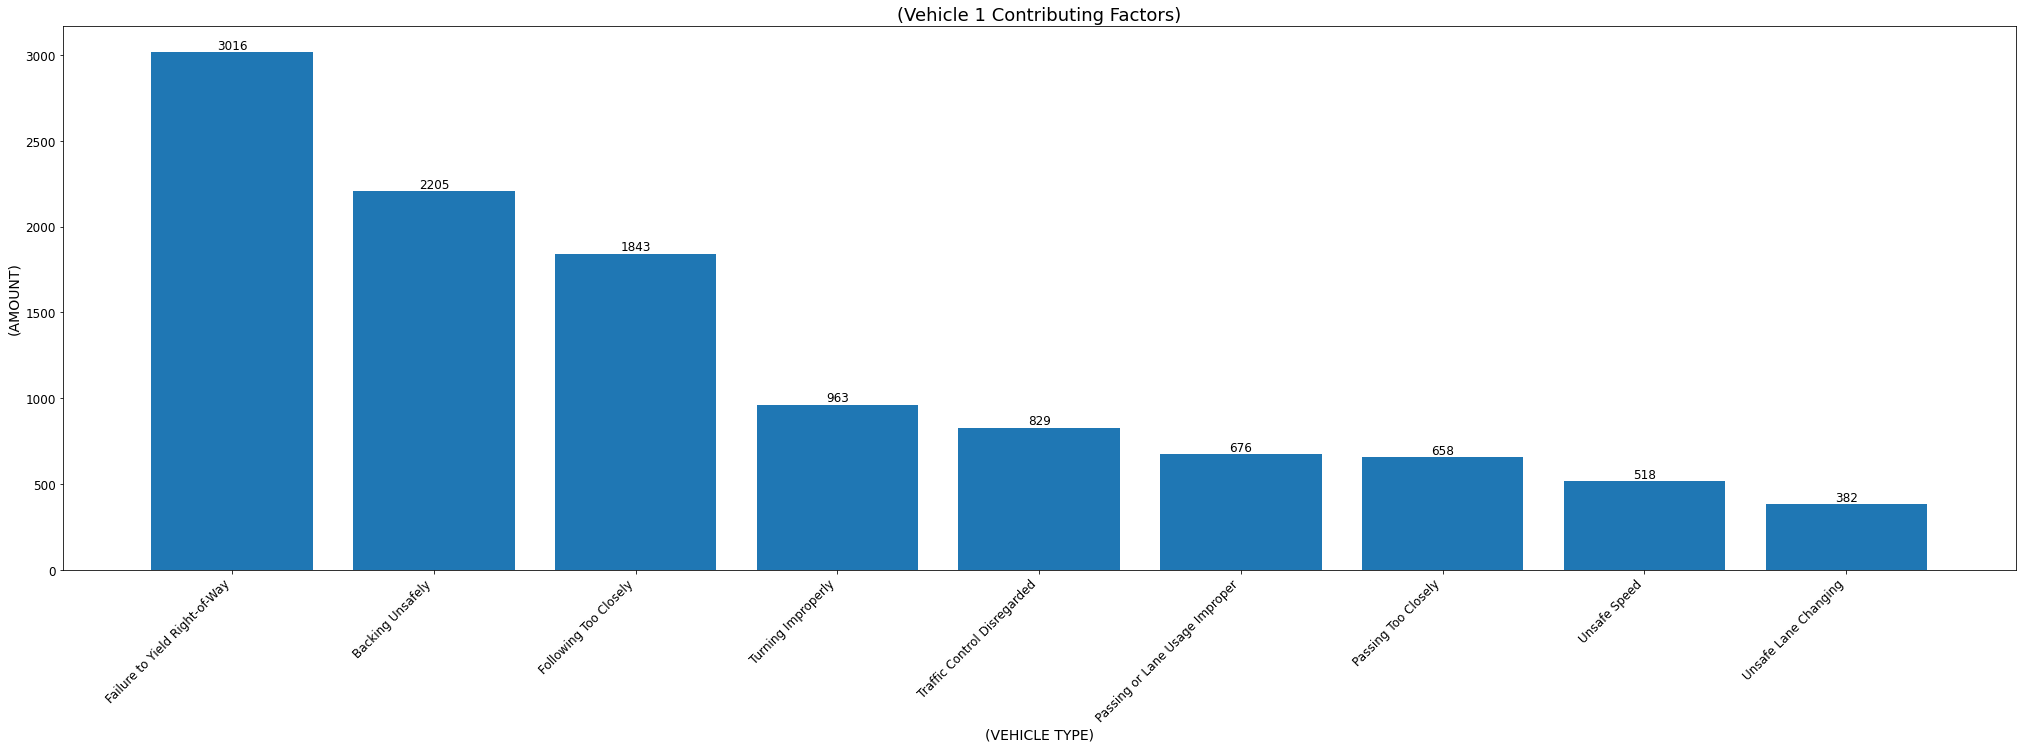

In [19]:
#Creating a bar chart after filtering vehicle 1 types to have a better visual
filter3 =['Failure to Yield Right-of-Way',  'Backing Unsafely', 'Following Too Closely', 'Turning Improperly', 'Traffic Control Disregarded', 'Passing or Lane Usage Improper', 
         'Passing Too Closely', 'Unsafe Speed', 'Unsafe Lane Changing' ]
C1 = MC_SI[MC_SI.contributing_factor_vehicle_1.isin(filter3)]       


CzF=C1.contributing_factor_vehicle_1.value_counts().rename_axis('Type').reset_index(name='counts') 


plt.rcParams['figure.figsize'] = (35,10)
plt.bar(CzF['Type'], CzF['counts'])
plt.xlabel('(VEHICLE TYPE)', fontsize = 14)
plt.ylabel('(AMOUNT)', fontsize = 14)
plt.xticks(rotation=45, horizontalalignment='right', fontsize = 12)
plt.yticks(fontsize = 12)
plt.title("(Vehicle 1 Contributing Factors)", fontsize = 18)


for i in range(len(CzF['Type'])):
    plt.text(i,CzF['counts'][i],CzF['counts'][i], ha='center', va='bottom', fontsize = 12)
    
plt.show()

In [20]:
filter3 =['Failure to Yield Right-of-Way',  'Backing Unsafely', 'Following Too Closely', 'Turning Improperly', 'Traffic Control Disregarded', 'Passing or Lane Usage Improper', 'Passing Too Closely', 'Unsafe Speed', 'Unsafe Lane Changing' ]
C1 = MC_SI[MC_SI.contributing_factor_vehicle_1.isin(filter3)]       
CFA = C1.contributing_factor_vehicle_1.value_counts().rename_axis('Type').reset_index(name='counts')


CF1 = C1.groupby('contributing_factor_vehicle_1')['zip_code'].value_counts().reset_index(name='counts')
print(CF1)

fig8 = px.treemap(CF1, path=['zip_code', 'contributing_factor_vehicle_1'], values = 'counts', color = 'counts',  color_continuous_scale ='RdYlGn')
fig8.update_layout(font_family="Open Sans")
fig8.update_layout(font_color='Black')
fig8.update_layout(title='(Contributing Factor for the Incident for Vehicle 1)')
fig8.show()

    contributing_factor_vehicle_1 zip_code  counts
0                Backing Unsafely    10306     483
1                Backing Unsafely    10305     343
2                Backing Unsafely    10312     279
3                Backing Unsafely    10301     235
4                Backing Unsafely    10304     201
..                            ...      ...     ...
99                   Unsafe Speed    10310      39
100                  Unsafe Speed    10308      36
101                  Unsafe Speed    10314      25
102                  Unsafe Speed    10307      10
103                  Unsafe Speed    10302       1

[104 rows x 3 columns]


In [21]:
filter3 =['Failure to Yield Right-of-Way',  'Backing Unsafely', 'Following Too Closely', 'Turning Improperly', 'Traffic Control Disregarded', 'Passing or Lane Usage Improper', 'Passing Too Closely', 'Unsafe Speed', 'Unsafe Lane Changing' ]
C2 = MC_SI[MC_SI.contributing_factor_vehicle_2.isin(filter3)]       
CFB = C2.contributing_factor_vehicle_2.value_counts().rename_axis('Type').reset_index(name='counts')


CF2 = C2.groupby('contributing_factor_vehicle_2')['zip_code'].value_counts().reset_index(name='counts')
print(CF2)

fig9 = px.treemap(CF2, path=['zip_code', 'contributing_factor_vehicle_2'], values = 'counts', color = 'counts',  color_continuous_scale ='RdYlGn')
fig9.update_layout(font_family="Open Sans")
fig9.update_layout(font_color='Black')
fig9.update_layout(title='(Contributing Factor for the Incident for Vehicle 2)')
fig9.show()

   contributing_factor_vehicle_2 zip_code  counts
0               Backing Unsafely    10306      53
1               Backing Unsafely    10305      40
2               Backing Unsafely    10312      33
3               Backing Unsafely    10301      32
4               Backing Unsafely    10304      27
..                           ...      ...     ...
84                  Unsafe Speed    10305       7
85                  Unsafe Speed    10308       7
86                  Unsafe Speed    10314       5
87                  Unsafe Speed    10309       4
88                  Unsafe Speed    10310       1

[89 rows x 3 columns]


In [22]:
filter3 =['Failure to Yield Right-of-Way',  'Backing Unsafely', 'Following Too Closely', 'Turning Improperly', 'Traffic Control Disregarded', 'Passing or Lane Usage Improper', 'Passing Too Closely', 'Unsafe Speed', 'Unsafe Lane Changing' ]
C3 = MC_SI[MC_SI.contributing_factor_vehicle_3.isin(filter3)]       
CFC = C3.contributing_factor_vehicle_3.value_counts().rename_axis('Type').reset_index(name='counts')


CF3 = C3.groupby('contributing_factor_vehicle_3')['zip_code'].value_counts().reset_index(name='counts')
print(CF3)

fig10 = px.treemap(CF3, path=['zip_code', 'contributing_factor_vehicle_3'], values = 'counts', color = 'counts',  color_continuous_scale ='RdYlGn')
fig10.update_layout(font_family="Open Sans")
fig10.update_layout(font_color='Black')
fig10.update_layout(title='(Contributing Factor for the Incident for Vehicle 3)')
fig10.show()

    contributing_factor_vehicle_3 zip_code  counts
0                Backing Unsafely    10310       2
1                Backing Unsafely    10304       1
2                Backing Unsafely    10305       1
3                Backing Unsafely    10306       1
4   Failure to Yield Right-of-Way    10306       3
5   Failure to Yield Right-of-Way    10307       1
6   Failure to Yield Right-of-Way    10308       1
7           Following Too Closely    10306       5
8           Following Too Closely    10301       4
9           Following Too Closely    10304       2
10          Following Too Closely    10308       2
11          Following Too Closely    10310       2
12          Following Too Closely    10314       2
13          Following Too Closely    10309       1
14    Traffic Control Disregarded    10304       1
15    Traffic Control Disregarded    10306       1
16           Unsafe Lane Changing    10305       1


### Looking into the Date Time

In [23]:
Date = MC_SI['crash_date'] = pd.to_datetime(pd.Series(MC_SI['crash_date']))
CT = Date.dt.strftime('%Y-%m')

print(MC_SI['crash_date'].head())

CY = MC_SI['crash_date'].dt.strftime('%Y')

Year = CY.value_counts().sort_index(ascending=True).rename_axis('Years').reset_index(name='counts')

print(Year)

18    2021-04-06
64    2021-04-14
88    2021-04-16
119   2021-04-14
128   2021-04-14
Name: crash_date, dtype: datetime64[ns]
  Years  counts
0  2012    4902
1  2013    8295
2  2014    6614
3  2015    6343
4  2016    5948
5  2017    6053
6  2018    5996
7  2019    3511
8  2020    2310
9  2021     698


In [24]:
fig11 = px.bar(Year, x = Year['Years'], y = Year['counts'], text = Year['counts'])
fig11.update_layout(font_family="Open Sans")
fig11.update_layout(font_color='Black')
fig11.update_yaxes(title_text= 'Number of Incidents')
fig11.update_traces(texttemplate='%{text:.4s}', textposition='outside')
fig11.update_layout(uniformtext_minsize=7, uniformtext_mode='hide')
fig11.update_layout(height=600)
fig11.update_layout(barmode='group', xaxis_tickangle=-45)
fig11.update_layout(title='(Accidents Jul 2012 - Present)')
fig11.update_layout(title_xanchor="left")
fig11.show()

In [25]:
CM = MC_SI['crash_date'].dt.strftime('%Y-%m')

Year_Month = CM.value_counts().sort_index(ascending=True).rename_axis('Year-Months').reset_index(name='counts')

print(Year_Month)

    Year-Months  counts
0       2012-07     768
1       2012-08     849
2       2012-09     808
3       2012-10     831
4       2012-11     798
..          ...     ...
101     2020-12     226
102     2021-01     204
103     2021-02     171
104     2021-03     174
105     2021-04     149

[106 rows x 2 columns]


In [26]:
fig12 = px.line(Year_Month, x = 'Year-Months', y = 'counts')
fig12.update_layout(font_family="Open Sans")
fig12.update_layout(font_color='Black')
fig12.update_yaxes(title_text= 'Number of Incidents')
fig12.update_traces(texttemplate='%{text:.4s}', textposition='top center')
fig12.update_layout(uniformtext_minsize=1, uniformtext_mode='hide')
fig12.update_layout(height=600)
fig12.update_layout(width=1000)
fig12.update_layout(xaxis_tickangle=-45)
fig12.update_layout(title='(Accidents Jul 2012 - Present)')
fig12.update_layout(title_xanchor="left")
fig12.show()

In [27]:
M = MC_SI['crash_date'].dt.month
Months = M.value_counts().sort_index(ascending=True).rename_axis('Month').reset_index(name='counts')

print(Months)

fig13 = px.line(Months, x = Months['Month'], y = Months['counts'], text = Months['counts'])
fig13.update_layout(font_family="Open Sans")
fig13.update_layout(font_color='Black')
fig13.update_yaxes(title_text= 'Number of Incidents')
fig13.update_traces(texttemplate='%{text:.4s}', textposition='top center')
fig13.update_layout(uniformtext_minsize=7, uniformtext_mode='hide')
fig13.update_layout(height=600)
fig13.update_layout(barmode='group', xaxis_tickangle=-45)
fig13.update_layout(title='(Accidents Jul 2012 - Present in Months)')
fig13.update_layout(title_xanchor="left")
fig13.show()

    Month  counts
0       1    4436
1       2    3934
2       3    3878
3       4    3300
4       5    4080
5       6    4177
6       7    4325
7       8    4348
8       9    4323
9      10    4725
10     11    4474
11     12    4670


### Looking into Hours of Each Days

In [28]:
Hour = MC_SI['crash_time'] = pd.to_datetime(pd.Series(MC_SI['crash_time']))
CH = Hour.dt.strftime('%H')

Hours = CH.value_counts().sort_index(ascending=True).rename_axis('Hour').reset_index(name='counts')

print(Hours)

   Hour  counts
0    00    1047
1    01     589
2    02     505
3    03     433
4    04     415
5    05     497
6    06     890
7    07    1370
8    08    2978
9    09    2584
10   10    2499
11   11    2625
12   12    3011
13   13    3162
14   14    3866
15   15    3554
16   16    4263
17   17    4032
18   18    3429
19   19    2678
20   20    2092
21   21    1663
22   22    1381
23   23    1107


In [29]:
fig14 = px.line(Hours, x = 'Hour', y = 'counts', text = 'counts')
fig14.update_layout(font_family="Open Sans")
fig14.update_layout(font_color='Black')
fig14.update_yaxes(title_text= 'Number of Incidents')
fig14.update_traces(texttemplate='%{text:.4s}', textposition='top left')
fig14.update_layout(uniformtext_minsize=7, uniformtext_mode='hide')
fig14.update_layout(height=600)
fig14.update_layout(barmode='group', xaxis_tickangle=-45)
fig14.update_layout(title='(Incidents in Hours)')
fig14.update_layout(title_xanchor="left")
fig14.show()

### Looking into Days of the week

In [30]:
D = MC_SI['crash_date'] = pd.to_datetime(pd.Series(MC_SI['crash_date']))
D = D.dt.strftime('%A')

Days = D.value_counts().rename_axis('Day').reset_index(name='counts')

print(Days)

         Day  counts
0     Friday    8260
1  Wednesday    7687
2   Thursday    7677
3    Tuesday    7572
4     Monday    7187
5   Saturday    6799
6     Sunday    5488


In [31]:
fig18 = px.line(Days, x = 'Day', y = 'counts', text = 'counts')
fig18.update_layout(font_family="Open Sans")
fig18.update_layout(font_color='Black')
fig18.update_yaxes(title_text= 'Number of Incidents')
fig18.update_traces(texttemplate='%{text:.4s}', textposition='top left')
fig18.update_layout(uniformtext_minsize=7, uniformtext_mode='hide')
fig18.update_layout(height=600)
fig18.update_layout(barmode='group', xaxis_tickangle=-45)
fig18.update_layout(title='(Incidents in Hours)')
fig18.update_layout(title_xanchor="left")
fig18.show()

### Creating Choropleth Map

In [32]:
from urllib.request import urlopen
import json
import pandas as pd
import folium
from folium.plugins import MarkerCluster # for clustering the markers

map = folium.Map(location=[40.5795, -74.1502], zoom_start=11)
map.choropleth(geo_data="https://raw.githubusercontent.com/fedhere/PUI2015_EC/master/mam1612_EC/nyc-zip-code-tabulation-areas-polygons.geojson",
             data=Z, # my dataset
             columns=['Zipcode', 'counts'], 
               featureidkey="Zipcode",
             key_on='feature.properties.postalCode',
             fill_color='OrRd', fill_opacity=0.7, line_opacity=0.2,
               legend_name = 'Accident per zipcode')


map

A:\Anaconda\lib\site-packages\folium\folium.py:409: FutureWarning:

The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.



### Creating a heatmap

In [33]:
import folium
from folium import plugins
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

m = folium.Map([40.5795, -74.1502], zoom_start=12)
m


# convert to (n, 2) nd-array format for heatmap


stationArr = MC_SI[['latitude', 'longitude']].to_numpy()

# plot heatmap
m.add_child(plugins.HeatMap(stationArr, radius=20))
m